In [ ]:

# cooperativity?

# look in literature for stuff about actual noise of antibody-antigen binding
# We need a name for this thing. Currently it's just called "the simulator"

# Things to do: maybe tune runtime? in noise?

# I suggest we rename excel file to 'Ab_binding_profiles_for_15_classes.xlsx'
# instead of the current file name, '15-class_Ab_binding_profiles.xlsx'
# This way, if we have more than one of these files, they'll group together under 
# alphabetic sorting,as in 'Ab_binding_profiles_for_n_classes.xlsx'

# But also, it might make sense to omit the number entirely from the filename, 
# and just have one file with all the binding profiels in it. We can use python
# to prune the pandas dataframe down to the ones we're using.

# I also suggest we put our excel files and other external data in a subfolder.
# Not sure what to call it. Maybe 'Lookup_tables'?

# Put a pin in it: note that the ellipses in the PCA plots are misleading. 
# The ellipse implies that we are fitting a Gaussian distribution and detecting
# a covariance structure, but actually we are starting with uncorrelated noise and 
# distorting it paraboliically. OK for now but we should be aware of this nuance, 
# and maybe in the future figure out a rigorous way to do this.

# TODO after 9/15/2025: 
# Legend on 3D plot
# move legend so doesn't block data
# implement Lines 9-19 KJM suggestions 

# 9/22/2025:
# fixed the legend placement.
# created a pared down affinities data frame for only the antibodies in use.
# TODO after 9/22/2025:
# implement Lines 9-19 KJM suggestions
# Make noise more realistic. Replicate the empirical noise of 15 classes RGB values from JMC.
# Add legend to 3D PCA plot


In [147]:
import random
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

    ██╗███╗   ██╗██╗████████╗██╗ █████╗ ██╗     ██╗███████╗███████╗
    ██║████╗  ██║██║╚══██╔══╝██║██╔══██╗██║     ██║╚══███╔╝██╔════╝
    ██║██╔██╗ ██║██║   ██║   ██║███████║██║     ██║  ███╔╝ █████╗  
    ██║██║╚██╗██║██║   ██║   ██║██╔══██║██║     ██║ ███╔╝  ██╔══╝  
    ██║██║ ╚████║██║   ██║   ██║██║  ██║███████╗██║███████╗███████╗
    ╚═╝╚═╝  ╚═══╝╚═╝   ╚═╝   ╚═╝╚═╝  ╚═╝╚══════╝╚═╝╚══════╝╚══════╝

In [148]:
# =================================
# Make table of nanoparticle colors
# =================================

color_channels = ("R", "G", "B",)
NP_names = ("Innova", "Red", "Blue")
NP_colors = [
#   Innova   Red     Blue
    [194.27, 178.77, 136.57, ],  # R
    [129.16, 127.22, 155.11, ],  # G
    [161.40, 154.64, 166.40, ],] # B

NP_colors = pd.DataFrame(
    NP_colors, 
    index = color_channels, 
    columns = NP_names,)

# # If you want to load the NP colors from an excel file:
# xls = pd.ExcelFile('NP_colors_RGB.xlsx')
# NP_colors = pd.read_excel(xls, 'NP_colors_RGB_09152025.xlsx', index_col = [0],)
# NP_names = tuple(NP_colors.columns.tolist()) # columns
# color_channels = tuple(NP_colors.index) # rows

In [149]:
# ==========================================
# Load table of idealized binding affinities
# ==========================================

# Currently, antibody binding profiles (mean_affinities) are 5 cols X 15 rows.
# Columns are antibodies, rows are antigens, i.e., 5 antibodies, 15 antigens.

xls = pd.ExcelFile('15-class_Ab_binding_profiles.xlsx')
mean_affinities = pd.read_excel(xls, 'Ab_profiles_08222025', index_col = [0],)
antibodies = tuple(mean_affinities.columns.tolist()) # columns
antigens = tuple(mean_affinities.index) # rows

In [150]:
# ==========================================================================
# Make tables of antibody pair interferences, initialize with 1.0 as default
# ==========================================================================

# 1.0 = no interference. This is the default value.

# The code below creates a dictionary, which maps each antigen to an antibody 
# interference table in the form of a square dataframe, where the columns and
# rows both correspond to antibodies. Each cell represents how those two 
# antibodies interfere with each other's binding to the antigen in question. 
# Values are initialized to the default of 1.0, meaning no interference.

interferences = {
    antigen: pd.DataFrame(
        data = 1.0, # default
        index = antibodies,
        columns = antibodies)
    for antigen in antigens}

# ========================================
# Declare specific pairs that do interfere
# ========================================

# Example: declare a symmetric interference of 0.5 for antibodies A and B.
# The strings 'some antigen', 'antibody A', and 'antibody B' need to correspond
# to the actual names of your antigen and your two antibodies, defined earlier.
# interferences['some antigen'].at['antibody A', 'antibody B'] = 0.5
# interferences['some antigen'].at['antibody B', 'antibody A'] = 0.5

# Currently, none are set to interfere

In [151]:
# ======================================
# Declare subset of antigens to test
# ======================================
# Antigens are the target analytes that bind to the antibodies on the test line and nanoparticle (immunoprobe). They are in the test solution
# We might want to test only a subset of antigens in the affinities Excel file.  Here 
# is where we can define that subset. Currently we use all of them, so we copy() 
# antigens
antigens_in_use = tuple(list(antigens).copy())

# ==================================
# Define subset of antibodies to use as test lines and immunoprobes
# ==================================

# "Test line" antibodies are the spots in the strip.
# Currently we spot all of them, so we copy() antibodies.
test_lines = tuple(list(antibodies).copy())

# "Immunoprobe" antibodies are incubated in the test solution.
# Each immunoprobe is conjugated with a dye nanoparticle (NP).
# Define pairings below: "immunoprobe": "NP"
immunoprobe_NPs = {
    "Dengue SinoBio": "Red", 
    "Dengue CTK": "Blue", 
    "Powassan": "Innova"}
immunoprobes = immunoprobe_NPs.keys()

# Sanity checks
for antigen in antigens_in_use:
    assert antigen in antigens
for test_line in test_lines:
    assert test_line in antibodies
for probe in immunoprobes:
    assert probe in antibodies
    NP_name = immunoprobe_NPs[probe]
    assert NP_name in NP_names

In [152]:
# ==================================
# Define antibodies in use out the whole pool
# ==================================

antibodies_in_use = tuple(set(test_lines) | set(immunoprobes))
mean_affins_of_Abs_in_use = mean_affinities.copy()
for column in mean_affins_of_Abs_in_use.columns.tolist():
    if column not in antibodies_in_use:
        mean_affins_of_Abs_in_use = mean_affins_of_Abs_in_use.drop(column, axis=1)

In [153]:
# ====================================================
# Define distribution of noise about each cluster mean 
# ====================================================

# If you test the same sample antigen repeatedly, using the same test lines and
# immunoprobes, you will generate a cluster of data, where each data point is a
# single test, and collectively they are spread around a mean that depends on
# the idealized binding affinities of your antibodies for your antigen. In this
# section we define the spread (variance) of that data for each antigen.

# Define target variance for each antigen. Currently arbitrary
variances = {antigen: 0.0005 for antigen in antigens}

# TODO write comment
noise_scaling_spot = 0.5
noise_scaling_sandwich = 0.2

# For each antigen, set covariance matrix to an identity matrix scaled by the
# desired target variance for that antigen. Identity matrix has size n, where n
# is the number of different antibodies we are using in our test.
identity_matrix = np.identity(len(antibodies_in_use))
cov_matrices = {antigen: identity_matrix * variances[antigen] for antigen in variances}

    ███████╗ █████╗ ██╗  ██╗███████╗    ██████╗  █████╗ ████████╗ █████╗ 
    ██╔════╝██╔══██╗██║ ██╔╝██╔════╝    ██╔══██╗██╔══██╗╚══██╔══╝██╔══██╗
    █████╗  ███████║█████╔╝ █████╗      ██║  ██║███████║   ██║   ███████║
    ██╔══╝  ██╔══██║██╔═██╗ ██╔══╝      ██║  ██║██╔══██║   ██║   ██╔══██║
    ██║     ██║  ██║██║  ██╗███████╗    ██████╔╝██║  ██║   ██║   ██║  ██║
    ╚═╝     ╚═╝  ╚═╝╚═╝  ╚═╝╚══════╝    ╚═════╝ ╚═╝  ╚═╝   ╚═╝   ╚═╝  ╚═╝

In [154]:
# ==========================
# Math to generate fake data
# ==========================

def add_noise_to_affins(
        antigen: str, 
        affins: pd.DataFrame,
        scaling: float = 1.0,
        ) -> pd.DataFrame:
    noisy_affins = affins.copy()
    deviations = np.random.multivariate_normal(
        mean = np.zeros(cov_matrices[antigen].shape[0]), 
        cov = cov_matrices[antigen])
    i = 0
    for antibody in antibodies_in_use:
        noisy_affins.loc[antigen, antibody] += (deviations[i] * scaling)
        i += 1
    return noisy_affins

def sandwich_color(
        antigen: str, 
        test_line: str, 
        immunoprobe: str, 
        affins: pd.DataFrame,
        add_noise: bool,
        ) -> pd.Series:
    '''Generate color channel data for a single sandwich'''
    if add_noise: affins = add_noise_to_affins(antigen, affins, noise_scaling_sandwich)
    NP_color = NP_colors[immunoprobe_NPs[immunoprobe]].copy()
    immunoprobe_affinity = affins.at[antigen, immunoprobe]
    test_line_affinity = affins.at[antigen, test_line]
    sandwich_affinity = test_line_affinity * immunoprobe_affinity
    interference = interferences[antigen].at[test_line, immunoprobe]
    return NP_color * sandwich_affinity * interference

def spot_color(
        antigen: str, 
        test_line: str, 
        affins: pd.DataFrame, 
        add_noise: bool,
        ) -> pd.Series:
    '''Generate combined color channel data for all sandwiches at a spot'''
    color = pd.Series([255.0]*len(color_channels), index = color_channels, dtype = float,)
    if add_noise: affins = add_noise_to_affins(antigen, affins, noise_scaling_spot)
    for probe in immunoprobes: 
        color -= sandwich_color(antigen, test_line, probe, affins, add_noise)
    return color

def strip_colors(antigen: str, add_noise: bool) -> pd.DataFrame:
    '''Generates a complete test strip for the given antigen with the RGB values for each test line'''
    affins = mean_affins_of_Abs_in_use
    if add_noise: affins = add_noise_to_affins(antigen, affins)
    result = pd.DataFrame(index = test_lines, columns = color_channels, dtype=float,)
    for test_line in test_lines: 
        result.loc[test_line] = spot_color(antigen, test_line, affins, add_noise)
    return result

def generate_strips(strips_per_antigen_in_use=1,add_noise = False) -> tuple[np.ndarray, list]:
    ''' Generate N strips for each antigen in use'''
    all_data = []
    all_labels = []

    for antigen in antigens_in_use:
        for _ in range(strips_per_antigen_in_use):
            strip = strip_colors(antigen, add_noise=add_noise)
            all_data.append(strip)
            all_labels.append(antigen)
 
    # Convert each strip to a RGB vector
    X = []
    for strip in all_data:
        flat=np.ravel(strip.to_numpy())
        X.append(flat)
    return (np.array(X), all_labels)

# 'strips' is the raw colorimetric data for all generated strips (all antigens in use)
# 'strip_labels' corresponds to strips, provides the antigen name for each entry in strips
strips, strip_labels = generate_strips(strips_per_antigen_in_use=100, add_noise=True)

     █████╗ ███╗   ██╗ █████╗ ██╗  ██╗   ██╗███████╗██╗███████╗
    ██╔══██╗████╗  ██║██╔══██╗██║  ╚██╗ ██╔╝██╔════╝██║██╔════╝
    ███████║██╔██╗ ██║███████║██║   ╚████╔╝ ███████╗██║███████╗
    ██╔══██║██║╚██╗██║██╔══██║██║    ╚██╔╝  ╚════██║██║╚════██║
    ██║  ██║██║ ╚████║██║  ██║███████╗██║   ███████║██║███████║
    ╚═╝  ╚═╝╚═╝  ╚═══╝╚═╝  ╚═╝╚══════╝╚═╝   ╚══════╝╚═╝╚══════╝

In [155]:
# =================
# 3-dimensional PCA
# =================

# Perform PCA 
pca_3D = PCA(n_components=3)
strips_pca_3D = pca_3D.fit_transform(strips)

# cluster_points_3D: break up all_data into subsets by antigen
cluster_points_3D = []
for antigen in antigens_in_use:
    mask = [label == antigen for label in strip_labels]
    cluster_points_3D.append(strips_pca_3D[mask])

# cluster_means_3D: the mean of the points in each cluster
cluster_means_3D = []
for cluster in cluster_points_3D:
    mean_of_points = np.mean(cluster, axis=0)
    cluster_means_3D.append(mean_of_points)

# cluster_covs_3D: the covariance matrices of the points in each cluster
cluster_covs_3D = []
for cluster in cluster_points_3D:
    cov_of_points = np.cov(cluster.T)
    cluster_covs_3D.append(cov_of_points)

# cluster_colors_3D: the color that each color will be plotted in
cluster_colors_3D = []
for _ in range(len(cluster_points_3D)):
    plot_color = str('#%02X%02X%02X' % (
        random.randint(0,255),
        random.randint(0,255),
        random.randint(0,255)))    
    cluster_colors_3D.append(plot_color)


In [156]:
# =================
# 2-dimensional PCA
# =================

# Perform PCA
pca_2D = PCA(n_components=2)
strips_pca_2D = pca_2D.fit_transform(strips)

# cluster_points_2D: break up all_data into subsets by antigen
cluster_points_2D = []
for antigen in antigens_in_use:
    mask = [label == antigen for label in strip_labels]
    cluster_points_2D.append(strips_pca_2D[mask])

# cluster_means_2D: the mean of the points in each cluster
cluster_means_2D = []
for cluster in cluster_points_2D:
    mean_of_points = np.mean(cluster, axis=0)
    cluster_means_2D.append(mean_of_points)

# cluster_covs_2D: the covariance matrices of the points in each cluster
cluster_covs_2D = []
for cluster in cluster_points_2D:
    cov_of_points = np.cov(cluster.T)
    cluster_covs_2D.append(cov_of_points)

# using same colors as 3D
cluster_colors_2D=cluster_colors_3D.copy()

    ██████╗ ██╗      ██████╗ ████████╗    ██████╗  █████╗ ████████╗ █████╗ 
    ██╔══██╗██║     ██╔═══██╗╚══██╔══╝    ██╔══██╗██╔══██╗╚══██╔══╝██╔══██╗
    ██████╔╝██║     ██║   ██║   ██║       ██║  ██║███████║   ██║   ███████║
    ██╔═══╝ ██║     ██║   ██║   ██║       ██║  ██║██╔══██║   ██║   ██╔══██║
    ██║     ███████╗╚██████╔╝   ██║       ██████╔╝██║  ██║   ██║   ██║  ██║
    ╚═╝     ╚══════╝ ╚═════╝    ╚═╝       ╚═════╝ ╚═╝  ╚═╝   ╚═╝   ╚═╝  ╚═╝

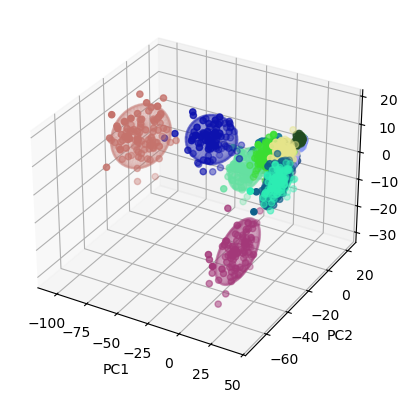

In [157]:
# Ellipsoid code from https://github.com/CircusMonkey/covariance-ellipsoid/blob/master/ellipsoid.py 
# August 2025

def get_cov_ellipsoid(cov, mu=np.zeros((3)), nstd=3):
    """
    Return the 3d points representing the covariance matrix
    cov centred at mu and scaled by the factor nstd.

    Plot on your favourite 3d axis. 
    Example 1:  ax.plot_wireframe(X,Y,Z,alpha=0.1)
    Example 2:  ax.plot_surface(X,Y,Z,alpha=0.1)
    """
    assert cov.shape==(3,3)

    # Find and sort eigenvalues to correspond to the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.sum(cov,axis=0).argsort()
    eigvals_temp = eigvals[idx]
    idx = eigvals_temp.argsort()
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    # Set of all spherical angles to draw our ellipsoid
    n_points = 100
    theta = np.linspace(0, 2*np.pi, n_points)
    phi = np.linspace(0, np.pi, n_points)

    # Width, height and depth of ellipsoid
    rx, ry, rz = nstd * np.sqrt(eigvals)

    # Get the xyz points for plotting
    # Cartesian coordinates that correspond to the spherical angles:
    X = rx * np.outer(np.cos(theta), np.sin(phi))
    Y = ry * np.outer(np.sin(theta), np.sin(phi))
    Z = rz * np.outer(np.ones_like(theta), np.cos(phi))

    # Rotate ellipsoid for off axis alignment
    old_shape = X.shape
    # Flatten to vectorise rotation
    X,Y,Z = X.flatten(), Y.flatten(), Z.flatten()
    X,Y,Z = np.matmul(eigvecs, np.array([X,Y,Z]))
    X,Y,Z = X.reshape(old_shape), Y.reshape(old_shape), Z.reshape(old_shape)
   
    # Add in offsets for the mean
    X = X + mu[0]
    Y = Y + mu[1]
    Z = Z + mu[2]
    
    return X,Y,Z


 # Setup the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('PC1')
plt.ylabel('PC2')

# plot data points and ellipses

nstd = 2 # number of standard deviations of ellipsoid; determines the ellipsoid volume

for antigen in antigens_in_use:
    i = antigens_in_use.index(antigen)
    points = cluster_points_3D[i]
    mean = cluster_means_3D[i]
    cov = cluster_covs_3D[i]
    plot_color = cluster_colors_3D[i] 
    X1,Y1,Z1 = get_cov_ellipsoid(cov, mean, nstd)
    ax.plot_wireframe(X1,Y1,Z1, color = plot_color, alpha=0.1)
    ax.scatter(points[:,0],points[:,1],points[:,2],c =plot_color)

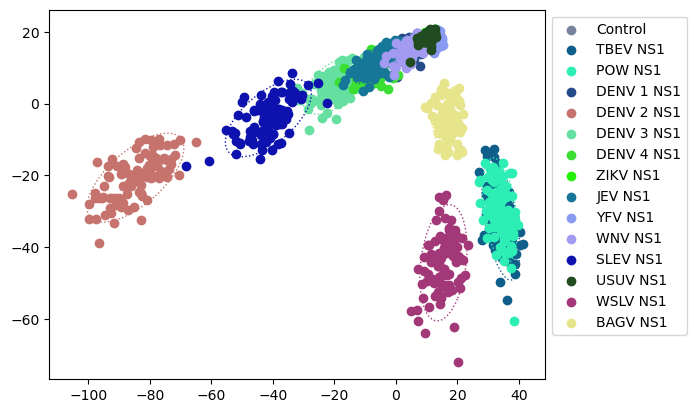

In [158]:
# plot the 2D PCA, legend

# from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


fig = plt.figure()
ax = fig.add_subplot(111,)

for antigen in antigens_in_use:
    i = antigens_in_use.index(antigen)
    cluster = cluster_points_2D[i]
    cluster_x = cluster[:,0]
    cluster_y = cluster[:,1]
    color=cluster_colors_2D[i]
    confidence_ellipse(cluster_x, cluster_y, ax, 2,  edgecolor=color, linestyle=':')
    ax.scatter(cluster_x, cluster_y, label = antigen, c=color)
ax.legend(bbox_to_anchor=(1, 1),)
ax.autoscale()
plt.show()





    ██████╗ ██████╗ ██╗███╗   ██╗████████╗     ██████╗ ██████╗ ██╗      ██████╗ ██████╗ ███████╗
    ██╔══██╗██╔══██╗██║████╗  ██║╚══██╔══╝    ██╔════╝██╔═══██╗██║     ██╔═══██╗██╔══██╗██╔════╝
    ██████╔╝██████╔╝██║██╔██╗ ██║   ██║       ██║     ██║   ██║██║     ██║   ██║██████╔╝███████╗
    ██╔═══╝ ██╔══██╗██║██║╚██╗██║   ██║       ██║     ██║   ██║██║     ██║   ██║██╔══██╗╚════██║
    ██║     ██║  ██║██║██║ ╚████║   ██║       ╚██████╗╚██████╔╝███████╗╚██████╔╝██║  ██║███████║
    ╚═╝     ╚═╝  ╚═╝╚═╝╚═╝  ╚═══╝   ╚═╝        ╚═════╝ ╚═════╝ ╚══════╝ ╚═════╝ ╚═╝  ╚═╝╚══════╝

In [159]:
# =================================================
# Prints the RGB values of all strips without noise
# =================================================

strips, strip_labels=generate_strips()
strips = list(strips)

column_names = []
for test_line in test_lines:
    column_names.append(f"R_{test_line}")
    column_names.append(f"G_{test_line}")
    column_names.append(f"B_{test_line}")

strips = pd.DataFrame(
    strips, 
    index = antigens_in_use, 
    columns = column_names,)

print(strips)
strips.to_csv('out.csv', index=True)


            R_Powassan  G_Powassan  B_Powassan  R_Dengue CTK  G_Dengue CTK  \
Control     255.000000  255.000000  255.000000    255.000000    255.000000   
TBEV NS1    216.580326  229.369840  223.010410    254.771758    254.847737   
POW NS1     217.959821  230.318575  224.182226    254.859722    254.906527   
DENV 1 NS1  255.000000  255.000000  255.000000    252.970632    253.418636   
DENV 2 NS1  255.000000  255.000000  255.000000    203.800863    206.704364   
DENV 3 NS1  254.983200  254.985262  254.983149    240.420723    242.210145   
DENV 4 NS1  253.976281  254.101910  253.972874    245.215521    246.416255   
ZIKV NS1    254.995096  254.995911  254.995259    254.669469    254.724410   
JEV NS1     255.000000  255.000000  255.000000    246.192629    247.110496   
YFV NS1     254.075539  254.383234  254.230390    255.000000    255.000000   
WNV NS1     254.971926  254.977917  254.973961    252.949008    253.386730   
SLEV NS1    254.700453  254.717977  254.683501    225.721762    

    ██████╗ ██╗      ██████╗ ████████╗    ██╗  ██╗ ██████╗ █████╗ 
    ██╔══██╗██║     ██╔═══██╗╚══██╔══╝    ██║  ██║██╔════╝██╔══██╗
    ██████╔╝██║     ██║   ██║   ██║       ███████║██║     ███████║
    ██╔═══╝ ██║     ██║   ██║   ██║       ██╔══██║██║     ██╔══██║
    ██║     ███████╗╚██████╔╝   ██║       ██║  ██║╚██████╗██║  ██║
    ╚═╝     ╚══════╝ ╚═════╝    ╚═╝       ╚═╝  ╚═╝ ╚═════╝╚═╝  ╚═╝

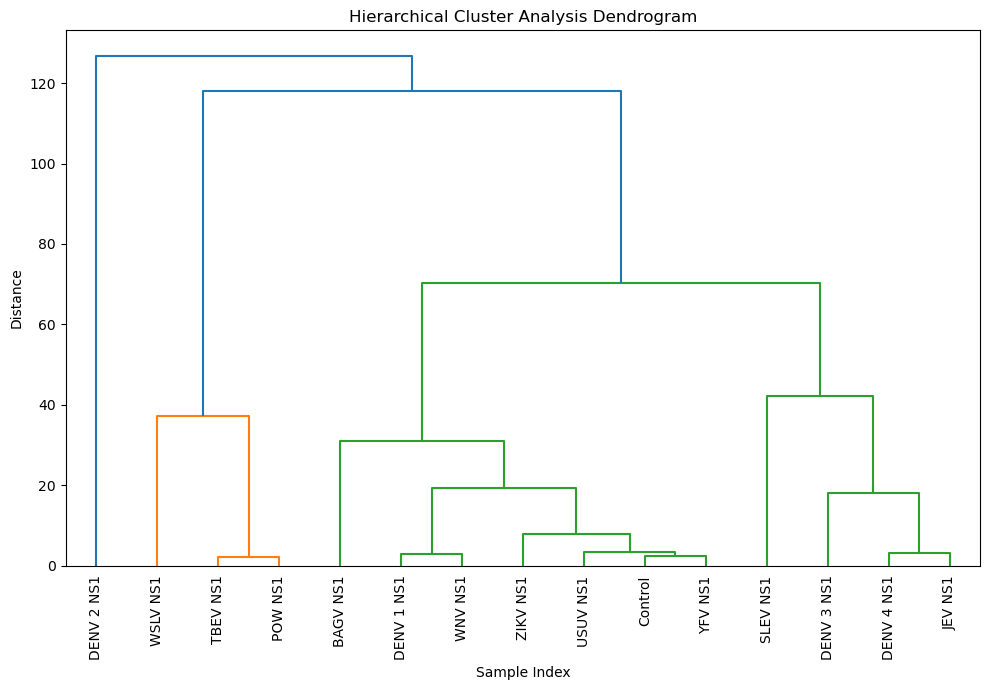

In [160]:
################################################################################
# New HCA code block: from GEMINI
################################################################################

# Perform hierarchical clustering on the same 6D data (X)
# We use the 'ward' method, which is good for minimizing the variance
# within each cluster, and 'euclidean' metric is the default and a good choice.
Z = sch.linkage(strips, method='ward')

# Create a figure for the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Cluster Analysis Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")

# Create the dendrogram
sch.dendrogram(
    Z,
    labels=strip_labels,
    leaf_rotation=90.,  # Rotate the leaf labels for better readability
    leaf_font_size=10.,
)

# You can add a horizontal line to "cut" the dendrogram and
# visually determine the clusters. A value of 't' for the fcluster function.
# plt.axhline(y=10, c='k', linestyle='--') # Example cut-off line

plt.tight_layout()
plt.show()

# To get the cluster assignments from the dendrogram, you can 'cut' it
# at a specific distance threshold. For example, a threshold of 10.
# You can adjust this value based on what you see in the dendrogram.
# from scipy.cluster.hierarchy import fcluster
# cluster_labels_hca = fcluster(Z, t=10, criterion='distance')
# print("HCA Cluster Labels:", cluster_labels_hca)

# You could also get a specific number of clusters.
# cluster_labels_hca_3 = fcluster(Z, t=3, criterion='maxclust')
# print("HCA Cluster Labels (3 clusters):", cluster_labels_hca_3)